*I have taken an approach to give score based on each attribute/feature and then finally take the cumulative weighted score.Everything else will be explained as we continue, no worries.*

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackerearth-love-in-the-time-of-screens/sample submission.csv
/kaggle/input/hackerearth-love-in-the-time-of-screens/data.csv
/kaggle/input/hackerearth-love-in-the-time-of-screens/sample dataset.csv
/kaggle/input/interest-bert-score/Interest_relation.csv


In [2]:
#Importing the necessary libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

!pip install -U sentence-transformers
!pip install ethnicolr
from ethnicolr import census_ln, pred_census_ln
import scipy

! pip install geotext
! pip install geopy
import geopandas as gpd

from urllib import request
from geotext import GeoText

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

from shapely.geometry import Point, Polygon
import descartes

     |████████████████████████████████| 65 kB 622 kB/s eta 0:00:011
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.0-py3-none-any.whl size=102651 sha256=5e5833a31864bc4d14d28cfa84246c6d188ea715505cfd298f072ee4faebe888
  Stored in directory: /root/.cache/pip/wheels/2a/8d/08/4a10448945e7a511061172df2c2a890e0d359e9a2060d89c44
Successfully built sentence-transformers
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 25.5 MB 40.4 MB/s eta 0:00:01


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.0 MB 865 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


*I have already found out the similarity score between different set of Interests and Jobs using BERT and stored them in the Interest_relation.csv and Job_relation.csv. So beside loading the data , I have also loaded those two tables under the alias ib and jb respectively.Donot worry , you will soon see their use in Interest score and Language score.* 

In [3]:
#Loading the Titanic Datasets 

df = pd.read_csv('../input/hackerearth-love-in-the-time-of-screens/data.csv')
sample_df = pd.read_csv('../input/hackerearth-love-in-the-time-of-screens/sample dataset.csv')
sample_sub = pd.read_csv('../input/hackerearth-love-in-the-time-of-screens/sample submission.csv')
ib = pd.read_csv('../input/interest-bert-score/Interest_relation.csv').drop(['Unnamed: 0'],axis=1)
jb = pd.read_csv('../input/jobbertscore/Job_relation.csv').drop(['Unnamed: 0'],axis=1)

df.head()

,user_id,username,age,status,sex,orientation,drinks,drugs,height,job,...,smokes,language,new_languages,body_profile,education_level,dropped_out,bio,interests,other_interests,location_preference
0,fffe3100,Edith Lopez,27,single,f,gay,socially,never,66.0,medicine / health,...,no,"english (fluently), spanish (poorly), sign lan...",interested,athletic,4.0,no,bottom line i love life! i work hard and i lov...,sports,instruments,same state
1,fffe3200,Travis Young,26,single,m,gay,socially,never,68.0,other,...,no,"english (fluently), tagalog (okay), french (po...",interested,fit,3.0,no,"i'm a straightforward, genuine, fun loving (i'...",painting,instruments,anywhere
2,fffe3300,Agnes Smith,20,seeing someone,f,bisexual,socially,sometimes,69.0,other,...,sometimes,"english (fluently), sign language (poorly), fr...",interested,fit,2.0,no,mmmmm yummy tacosss. yoga is where it's at. i ...,instruments,dancing,same city
3,fffe3400,Salvador Klaver,27,single,m,bisexual,socially,sometimes,68.0,computer / hardware / software,...,no,english,not interested,average,3.0,no,i'm a stealth geek. that special mix of techni...,sketching,acting,same city
4,fffe3500,Elana Sewell,22,single,f,bisexual,often,sometimes,68.0,other,...,yes,english,not interested,average,2.0,yes,with the whisper of the wind i was weaved into...,craft,designing,same city


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              2001 non-null   object 
 1   username             2001 non-null   object 
 2   age                  2001 non-null   int64  
 3   status               2001 non-null   object 
 4   sex                  2001 non-null   object 
 5   orientation          2001 non-null   object 
 6   drinks               2001 non-null   object 
 7   drugs                2001 non-null   object 
 8   height               2001 non-null   float64
 9   job                  2001 non-null   object 
 10  location             2001 non-null   object 
 11  pets                 2001 non-null   object 
 12  smokes               2001 non-null   object 
 13  language             2001 non-null   object 
 14  new_languages        2001 non-null   object 
 15  body_profile         2001 non-null   o

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf1b7b86d0>,
      dtype=object)

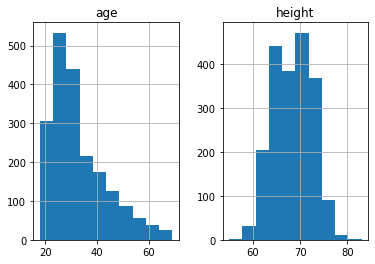

In [5]:
df[['age','height']].hist()

# Bio Score

In [11]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:24<00:00, 16.5MB/s] 


In [46]:
def bert(d1,d2):
  s1 = d1.bio_model.iloc[0]
  s2 = d2.bio_model.iloc[0]
  
  cosine = scipy.spatial.distance.cosine(s1,s2)

  return round((1-cosine)*100,2)

*The bio_model column contains the BERT encodings for the respective bio.BERT is a pretrained model which convert a sentence to an array so that machine can read them.*

In [53]:
def bert_transform(data):
    data['bio_model'] = data.bio.apply(lambda x: sbert_model.encode(x))
    return data

sample_df = bert_transform(sample_df)
sample_df.bio_model

0    [-0.17635715, 0.5200183, 1.1787245, 0.03718057...
1    [-0.31975803, 0.54620904, 0.69349736, 0.034020...
2    [-0.13367344, 0.6544402, 0.5067266, -0.1934924...
3    [-0.059696753, 0.8612904, 0.17461835, 0.006152...
4    [-0.020114746, 0.12041509, 0.8955123, 0.599275...
Name: bio, dtype: object

In [55]:
bert(sample_df.iloc[[0]],sample_df.iloc[[2]])

76.45

# Location Score

Using Geoparsing method I have extracted the latitude and longitude from the city names.

Credit - https://towardsdatascience.com/geoparsing-with-python-c8f4c9f78940

In [13]:
df.cities = df.location.apply(lambda x: x.split(', ')[0])
df.cities.head()

0          oakland
1    pleasant hill
2          oakland
3        daly city
4          oakland
Name: location, dtype: object

In [18]:
geolocator = Nominatim(timeout=2,user_agent="smy-application")
lat_lon = []
k=0
for city in df.cities: 
    try:
        location = geolocator.geocode(city)
        if location:
            #print(location.latitude, location.longitude)
            lat_lon.append(location)
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"(city, e))
    if k%50==0:
        print("No. of iteration {}".format(k))
    k+=1
lat_lon[0:5]

No. of iteration 0
No. of iteration 50
No. of iteration 100
No. of iteration 150
No. of iteration 200
No. of iteration 250
No. of iteration 300
No. of iteration 350
No. of iteration 400
No. of iteration 450
No. of iteration 500
No. of iteration 550
No. of iteration 600
No. of iteration 650
No. of iteration 700
No. of iteration 750
No. of iteration 800
No. of iteration 850
No. of iteration 900
No. of iteration 950
No. of iteration 1000
No. of iteration 1050
No. of iteration 1100
No. of iteration 1150
No. of iteration 1200
No. of iteration 1250
No. of iteration 1300
No. of iteration 1350
No. of iteration 1400
No. of iteration 1450
No. of iteration 1500
No. of iteration 1550
No. of iteration 1600
No. of iteration 1650
No. of iteration 1700
No. of iteration 1750
No. of iteration 1800
No. of iteration 1850
No. of iteration 1900
No. of iteration 1950
No. of iteration 2000


[Location(Oakland, Alameda County, California, United States, (37.8044557, -122.2713563, 0.0)),
 Location(Pleasant Hill, Contra Costa County, California, 94523, United States, (37.9479786, -122.0607963, 0.0)),
 Location(Oakland, Alameda County, California, United States, (37.8044557, -122.2713563, 0.0)),
 Location(Daly City, San Mateo County, California, United States, (37.6904826, -122.4726708, 0.0)),
 Location(Oakland, Alameda County, California, United States, (37.8044557, -122.2713563, 0.0))]

In [27]:
lat_lon = [[i.latitude,i.longitude] for i in lat_lon]

In [28]:
se = pd.Series(lat_lon)
df['lat_Lon'] = se.values

In [29]:
def loc_transform(data):
  LocationList = str(data['location']).split(",")
  data['City'] = LocationList[0]
  data['State'] = LocationList[1]
  return data

sample_df = loc_transform(sample_df)
se = pd.Series(lat_lon[0:5])
sample_df['lat_Lon'] = se.values

In [39]:
from math import sin, cos, sqrt, atan2, radians
def distance(LL1,LL2):
  # approximate radius of earth in km
  R = 6373.0

  lat1 = radians(LL1[0])
  lon1 = radians(LL1[1])
  lat2 = radians(LL2[0])
  lon2 = radians(LL2[1])

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance


def loc_score(d1,d2):
  score=0
  dis = distance(d1.lat_Lon.iloc[0],d2.lat_Lon.iloc[0])
  if(d1.location_preference.iloc[0] == 'same city' and dis == 0):
    score = 100
  elif(d1.location_preference.iloc[0] == 'same city' and 0< dis <= 10 ) :
    score = 90
  elif(d1.location_preference.iloc[0] == 'same city' and 10< dis <= 20 ) :
    score = 80
  elif(d1.location_preference.iloc[0] == 'same city' and 20< dis <= 30 ) :
    score = 70
  elif(d1.location_preference.iloc[0] == 'same city' and 30< dis <= 40 ) :
    score = 60
  elif(d1.location_preference.iloc[0] == 'same city' and 0< dis <= 50 ) :
    score = 50
  elif(d1.location_preference.iloc[0] == 'same city' and 50 <dis <= 100 ) :
    score = 30
  elif(d1.location_preference.iloc[0] == 'same city' and 100 <dis <= 200 ) :
    score = 10
  elif(d1.State.iloc[0] == d2.State.iloc[0] and d1.location_preference.iloc[0] == 'same state' ):
    score = 100
  elif(d1.location_preference.iloc[0] == 'anywhere' and dis <= 10):
    score = 100
  elif(d1.location_preference.iloc[0] == 'anywhere' and 10 < dis <= 100 ):
    score = 75
  elif(d1.location_preference.iloc[0] == 'anywhere' and 100 < dis <= 200 ):
    score = 50
  elif(d1.location_preference.iloc[0] == 'anywhere' and 200 < dis <= 500 ):
    score = 25 
  return score

In [40]:
loc_score(sample_df.iloc[[0]],sample_df.iloc[[4]])

100

# Interest Score

In [9]:
df.iloc[[0]][['interests','other_interests']].values.tolist()

[['sports', 'instruments']]

In [10]:
def interest_trans(data):
    data['interests'] = data[['interests','other_interests']].values.tolist()
    return data
   
sample_df = interest_trans(sample_df)

sample_df.interests.head(1)

0    [sports, instruments]
Name: interests, dtype: object

In [11]:
df = interest_trans(df)
List = df.interests.tolist()
flat_list = [item for sublist in List for item in sublist]
flat_list[0:4]

['sports', 'instruments', 'painting', 'instruments']

In [12]:
 from collections import Counter
 len(Counter(flat_list))

31

In [12]:
#This is the method by which I have created the Interest_relation.csv

from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

first=[]
second=[]
similarity=[]
for i in set(flat_list):
  for j in set(flat_list):
    document_embeddings1 = sbert_model.encode(i)
    document_embeddings2 = sbert_model.encode(j)
    cosine = scipy.spatial.distance.cosine(document_embeddings1,document_embeddings2)

    first.append(i)
    second.append(j)
    similarity.append(round((1-cosine)*100,2))
    
    
d = {'first':first,'second':second,'similarity':similarity}
ib = pd.DataFrame(d)


,first,second,similarity
0,sketching,sketching,100.00
1,sketching,acting,59.56
2,sketching,astronomy,38.10
3,sketching,craft,63.03
4,sketching,writting,61.61


In [13]:
ib.head()

,first,second,similarity
0,camping,camping,100.00
1,camping,sports,41.97
2,camping,makeup,34.84
3,camping,food,56.22
4,camping,painting,38.19


In [14]:
df.interests[0:5]

0      [sports, instruments]
1    [painting, instruments]
2     [instruments, dancing]
3        [sketching, acting]
4         [craft, designing]
Name: interests, dtype: object

*We have done this way because encoding(making words into array) and calculating BERT similarity during the running of Main_Function takes lots of time.*

In [15]:
def int_score(d1,d2):
  l1 = d1.interests.iloc[0]
  l2 = d2.interests.iloc[0]
  bert_score=0
  if l1 and l2:
    for i in l1:
      for j in l2:
        bert_score+= ib[(ib['first']==i) & (ib['second']==j) ].similarity.iloc[0]
  
  return bert_score/4

In [16]:
int_score(df.iloc[[4]],df.iloc[[5]])

50.21

# Job score

In [99]:
df.job.value_counts()

other                                286
student                              226
artistic / musical / writer          176
science / tech / engineering         163
medicine / health                    158
computer / hardware / software       156
sales / marketing / biz dev          156
education / academia                 131
executive / management                93
banking / financial / real estate     79
entertainment / media                 78
law / legal services                  54
construction / craftsmanship          52
hospitality / travel                  46
clerical / administrative             34
political / government                33
transportation                        22
retired                               18
rather not say                        17
unemployed                            16
military                               7
Name: job, dtype: int64

In [28]:
def job_list(string):
  l = string.split('/')
  l = [word.strip() for word in l]
  l = [word for word in l if word not in ['rather not say','unemployed','other']]
  return l

sample_df['job_list'] = sample_df['job'].apply(lambda x: job_list(x))
sample_df.job_list

0                [medicine, health]
1                                []
2                                []
3    [computer, hardware, software]
4                                []
Name: job_list, dtype: object

In [18]:
jb['firstname'] = jb.name.apply(lambda x : x.split(' and ')[0].strip().replace('[','').replace(']','').replace("'",""))
jb['second'] = jb.name.apply(lambda x : x.split(' and ')[1].strip().split(' are ')[0].replace('[','').replace(']','').replace("'",""))
jb['similarity'] = jb.name.apply(lambda x : float(x.split(' and ')[1].strip().split(' are ')[1].split('to ')[1].replace('%','')))
jb.head()

,name,firstname,second,similarity
0,['student'] and ['student'] are similar to 10...,student,student,100.00
1,"['student'] and ['artistic', 'musical', 'writ...",student,"artistic, musical, writer",48.92
2,"['student'] and ['science', 'tech', 'engineer...",student,"science, tech, engineering",45.80
3,"['student'] and ['medicine', 'health'] are si...",student,"medicine, health",35.75
4,"['student'] and ['computer', 'hardware', 'sof...",student,"computer, hardware, software",48.32


In [20]:
def trans_list(l):
  return str(l).replace("[","").replace(']','').replace("'",'')

#def trans_string(string):
#  return string.replace('[','').replace(']','').replace("'","").split(', ')

def job_bert(d1,d2):
  l1 = d1.job_list.iloc[0]
  l2 = d2.job_list.iloc[0]
  if l1 and l2:
    bert_score = jb[(jb['firstname']==trans_list(l1)) & (jb['second']==trans_list(l2)) ].similarity.iloc[0]
  else:
    bert_score=0
  return bert_score

In [25]:
job_bert(sample_df.iloc[[0]],sample_df.iloc[[3]])

42.44

# Pets score

In [57]:
df.pets.value_counts()

likes dogs and likes cats          743
likes dogs                         303
likes dogs and has cats            229
has dogs                           184
has dogs and likes cats            148
likes dogs and dislikes cats       121
has dogs and has cats               87
has cats                            63
likes cats                          59
has dogs and dislikes cats          24
dislikes dogs and dislikes cats     17
dislikes dogs and likes cats         9
dislikes dogs                        5
dislikes cats                        5
dislikes dogs and has cats           4
Name: pets, dtype: int64

In [56]:
def pets_trans(data):
  data['likes_dogs'] = data.pets.apply(lambda x: 1 if 'likes dogs' in x else (1 if 'has dogs' in x else 0 ) )
  data['has_dogs'] = data.pets.apply(lambda x: 1 if 'has dogs' in x else 0 )
  data['likes_cats'] = data.pets.apply(lambda x: 1 if 'likes cats' in x else (1 if 'has cats' in x else 0 ) )
  data['has_cats'] = data.pets.apply(lambda x: 1 if 'has cats' in x else 0 )
  data['dislikes_dogs'] = data.pets.apply(lambda x: 1 if 'dislikes dogs' in x else 0 )
  data['dislikes_cats'] = data.pets.apply(lambda x: 1 if 'dislikes cats' in x else 0 )
  return data

sample_df = pets_trans(sample_df)
sample_df.head(1)

,user_id,username,age,status,sex,orientation,drinks,drugs,height,job,...,City,State,lat_Lon,bio_model,likes_dogs,has_dogs,likes_cats,has_cats,dislikes_dogs,dislikes_cats
0,fffe3100,Edith Lopez,27,single,f,gay,socially,never,66.0,medicine / health,...,0 oakland,california\n1 pleasant hill,"[37.8044557, -122.2713563]","[-0.17635715, 0.5200183, 1.1787245, 0.03718057...",1,0,1,0,0,0


In [58]:
def pets_score(d1,d2):
  score = 0
  if (d1.likes_dogs.iloc[0] == 1 and d2.likes_dogs.iloc[0] == 1):
    score+=100
  if (d1.likes_dogs.iloc[0] == 1 and d2.has_dogs.iloc[0] == 1):
    score+=100
  if (d1.has_dogs.iloc[0] == 1 and d2.likes_dogs.iloc[0] == 1):
    score+=100
  if (d1.dislikes_dogs.iloc[0] == 1 and d2.dislikes_dogs.iloc[0] == 1):
    score+=100

  if (d1.likes_cats.iloc[0] == 1 and d2.likes_cats.iloc[0] == 1):
    score+=100
  if (d1.likes_cats.iloc[0] == 1 and d2.has_cats.iloc[0] == 1):
    score+=100
  if (d1.has_cats.iloc[0] == 1 and d2.likes_cats.iloc[0] == 1):
    score+=100
  if (d1.dislikes_cats.iloc[0] == 1 and d2.dislikes_cats.iloc[0] == 1):
    score+=100

  if (d1.likes_dogs.iloc[0] == 1 and d2.dislikes_dogs.iloc[0] == 1):
    score-=50
  if (d1.dislikes_dogs.iloc[0] == 1 and d2.likes_dogs.iloc[0] == 1):
    score-=50
  if (d1.has_dogs.iloc[0] == 1 and d2.dislikes_dogs.iloc[0] == 1):
    score-=100
  if (d1.dislikes_dogs.iloc[0] == 1 and d2.has_dogs.iloc[0] == 1):
    score-=100

  if (d1.likes_cats.iloc[0] == 1 and d2.dislikes_cats.iloc[0] == 1):
    score-=50
  if (d1.dislikes_cats.iloc[0] == 1 and d2.likes_cats.iloc[0] == 1):
    score-=50
  if (d1.has_cats.iloc[0] == 1 and d2.dislikes_cats.iloc[0] == 1):
    score-=100
  if (d1.dislikes_cats.iloc[0] == 1 and d2.has_cats.iloc[0] == 1):
    score-=100

  

  return score/4

In [59]:
pets_score(sample_df.iloc[[0]],sample_df.iloc[[4]])

50.0

# Language Score

In [60]:
def lang_list(string):
  l =string.split(',')
  l = [word.strip()for word in l]
  m=[]
  n=[]
  for word in l:
    if word.startswith('eng'):
      pass
    else:
      m.append(word)
  for word in m:
    n.append(word.split(' ')[0])
  return n

*English is very common among all the datapoints so I have created a separate attribute 'Know_english'. Apart from english , the other languages were stored in a list, through the lang_list() function.*

In [61]:
def language(data):
  data['know_english'] = data['language'].apply(lambda x: 0 if x.startswith('english (poorly)') else 1 )
  data['other_lang'] = data['language'].apply(lambda x: lang_list(x))
  return data

In [62]:
sample_df = language(sample_df)
sample_df.head(1)

,user_id,username,age,status,sex,orientation,drinks,drugs,height,job,...,lat_Lon,bio_model,likes_dogs,has_dogs,likes_cats,has_cats,dislikes_dogs,dislikes_cats,know_english,other_lang
0,fffe3100,Edith Lopez,27,single,f,gay,socially,never,66.0,medicine / health,...,"[37.8044557, -122.2713563]","[-0.17635715, 0.5200183, 1.1787245, 0.03718057...",1,0,1,0,0,0,1,"[spanish, sign]"


In [66]:
def lang_score(d1,d2):
  score = 100 if d1.know_english.iloc[0] else 0
  c = sum(el in d1.other_lang.iloc[0] for el in d2.other_lang.iloc[0])
  score+= (100*c)
  if c ==0 and d1.new_languages.iloc[0]=='interested':
    score+=50
  if c ==0 and d2.new_languages.iloc[0]=='interested':
    score+=50
  return score/3

In [67]:
lang_score(sample_df.iloc[[0]],sample_df.iloc[[4]])

50.0

# Ethnicity score from username

*This is done by taking the help of  a pre created python package which determines the race based on last_name of observants. Although it is debatable to use race in algorithm but thinking of human approach of matching, we have included this section.*

In [69]:
def ethnicity(data):
  data['last_name'] = data['username'].apply(lambda x : x.split(' ')[1])
  data['race'] = pred_census_ln(data[['last_name']], 'last_name', year=2010)['race']
  return data

In [70]:
ethnicity(sample_df)
sample_df.head(1)

1/1 - 0s
1/1 - 0s


,user_id,username,age,status,sex,orientation,drinks,drugs,height,job,...,likes_dogs,has_dogs,likes_cats,has_cats,dislikes_dogs,dislikes_cats,know_english,other_lang,last_name,race
0,fffe3100,Edith Lopez,27,single,f,gay,socially,never,66.0,medicine / health,...,1,0,1,0,0,0,1,"[spanish, sign]",Lopez,hispanic


In [71]:
def race_score(d1,d2):
  score=0
  if d1.race.iloc[0] == d2.race.iloc[0]:
    score+=100
  return score

In [72]:
race_score(sample_df.iloc[[0]],sample_df.iloc[[4]])

0

# Age Score

*We have found out the euclidean distance between two participants age and normalise it to fall in between (0,100).*

In [76]:
def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))


def normalisation(OldValue,OldMax,OldMin):
  NewMax=100
  NewMin=0
  #OldValue=score

  OldRange = (OldMax - OldMin)  
  NewRange = (NewMax - NewMin)  
  NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
  return NewValue

def age_score(d1,d2):
  score = euclidean_distance(d1.age.iloc[0],d2.age.iloc[0])
  return normalisation( round(100-score,2),100,49)


In [81]:
age_score(sample_df.iloc[[0]],sample_df.iloc[[2]])

86.27450980392157

# Body Profile Score

In [83]:
a = ['average', 'fit', 'athletic','jacked']
b = ['curvy', 'a little extra','full figured', 'overweight']
c = ['thin','skinny']

In [84]:
def body_score(d1,d2):
  score=0
  if d1.body_profile.iloc[0] in a and d2.body_profile.iloc[0] in a:
    score+=100
  if d1.body_profile.iloc[0] in b and d2.body_profile.iloc[0] in b:
    score+=100
  if d1.body_profile.iloc[0] in c and d2.body_profile.iloc[0] in c:
    score+=100
    
  return score

In [88]:
body_score(sample_df.iloc[[0]],sample_df.iloc[[3]])

100

# DDS Score

In [89]:
print(df.drinks.value_counts().index)
print('-'*50)

print(df.smokes.value_counts().index)
print('-'*50)

print(df.drugs.value_counts().index)
print('-'*50)

Index(['socially', 'rarely', 'often', 'not at all', 'very often',
       'desperately'],
      dtype='object')
--------------------------------------------------
Index(['no', 'sometimes', 'yes', 'when drinking', 'trying to quit'], dtype='object')
--------------------------------------------------
Index(['never', 'sometimes', 'often'], dtype='object')
--------------------------------------------------


In [90]:
drinks_yes = ['very often','desperately','often']
drinks_rare = ['socially', 'rarely']
drinks_no = ['not at all']

smokes_yes = ['sometimes', 'yes', 'when drinking', 'trying to quit']
smokes_no = ['no']

drugs_yes = ['sometimes','often']
drugs_no = ['never']

In [91]:
def dds_score(d1,d2):
  score = 0
  if (d1.drinks.iloc[0] in drinks_yes and d2.drinks.iloc[0] in drinks_yes):
    score +=100
  elif (d1.drinks.iloc[0] in drinks_yes and d2.drinks.iloc[0] in drinks_rare):
    score +=50
  elif (d1.drinks.iloc[0] in drinks_rare and d2.drinks.iloc[0] in drinks_yes):
    score +=50
  elif (d1.drinks.iloc[0] in drinks_rare and d2.drinks.iloc[0] in drinks_rare):
    score+=100
  elif (d1.drinks.iloc[0] in drinks_no and d2.drinks.iloc[0] in drinks_no):
    score +=100
  elif (d1.drinks.iloc[0] in drinks_rare and d2.drinks.iloc[0] in drinks_no):
    score +=50
  elif (d1.drinks.iloc[0] in drinks_no and d2.drinks.iloc[0] in drinks_rare):
    score +=50

  if (d1.smokes.iloc[0] in smokes_yes and d2.smokes.iloc[0] in smokes_yes):
    score +=100 
  elif (d1.smokes.iloc[0] in smokes_no and d2.smokes.iloc[0] in smokes_no):
    score +=100

  if (d1.drugs.iloc[0] in drugs_yes and d2.drugs.iloc[0] in drugs_yes):
    score +=100 
  elif (d1.drugs.iloc[0] in drugs_no and d2.drugs.iloc[0] in drugs_no):
    score +=100

  return score/3

In [92]:
dds_score(sample_df.iloc[[0]],sample_df.iloc[[3]])

66.66666666666667

# Education Score

In [94]:
def edu_score(d1,d2):
  score=0
  if (d2.education_level.iloc[0] == d1.education_level.iloc[0]):
    score+=100
  if (d2.education_level.iloc[0] == d1.education_level.iloc[0] - 1):
    score+=50
  if (d2.education_level.iloc[0] == d1.education_level.iloc[0] + 1):
    score+=50
  if (d2.education_level.iloc[0] == d1.education_level.iloc[0] - 2):
    score+=25
  if (d2.education_level.iloc[0] == d1.education_level.iloc[0] + 2):
    score+=25
  if (d1.dropped_out.iloc[0] == d2.dropped_out.iloc[0]):
    if score == 100 :
      score += 100
    else:
      score +=50
       
  return score/2

In [95]:
edu_score(sample_df.iloc[[0]],sample_df.iloc[[3]])

50.0

# Status Score

In [96]:
df.status.value_counts().index

Index(['single', 'available', 'seeing someone', 'married'], dtype='object')

In [97]:
a = ['single', 'available']
b = ['seeing someone', 'married']

def status_score(d1,d2):
  score=0
  if (d1.status.iloc[0] in a and d2.status.iloc[0] in a):
    score +=100
  return score

In [98]:
status_score(sample_df.iloc[[0]],sample_df.iloc[[3]])

100

# Orientation Score

In [29]:
df.groupby(["orientation","sex"]).count()['user_id']

orientation  sex
bisexual     f       84
             m       28
gay          f       40
             m      113
straight     f      738
             m      998
Name: user_id, dtype: int64

In [30]:
def ori_score(d1,d2):
  score = 0
  if (d1.orientation.iloc[0] == 'straight' and d2.orientation.iloc[0] == 'straight'):
    score += 100
  elif (d1.orientation.iloc[0] == 'gay' and d2.orientation.iloc[0] == 'gay'):
    score += 100 
  elif (d1.orientation.iloc[0] == 'bisexual' and d2.orientation.iloc[0] == 'bisexual'):
    score += 100 
  
  return score

In [35]:
ori_score(sample_df.iloc[[1]],sample_df.iloc[[0]])

100

# Final Model

In [37]:
def fin_trans(data):

  data = bert_transform(data) #bio
  data = loc_transform(data) #location
# data = interest_trans(data) #interest
  data['job_list'] = data['job'].apply(lambda x: job_list(x)) #job
  data = pets_trans(data) #pets
  data = language(data)   #language
  data = ethnicity(data)
  return data


In [ ]:
df = fin_trans(df)
df.columns

In [42]:
weights = {"bio":0.15,"job":0.05,"interest":0.05,"race":0.05,"age":0.15,"location":0.15
           ,"drinks_drugs_smokes":0.05,'language' :0.05 ,
           "pets":0.05,"education_level":0.05,"status":0.05,"body_profile":0.05,"orientation":0.10}

In [47]:
round(sum(weights.values()),3)

1.0

In [48]:
def score_fin(d1,d2):
    
  # age score
  age_sc = age_score(d1,d2)* weights['age']
 
  # location score
  loca_sc = loc_score(d1,d2) * weights['location']

  # drinks_drugs_smokes score
  dds_sc = dds_score(d1,d2) * weights['drinks_drugs_smokes']

  # job score
  job_sc = job_bert(d1,d2) * weights['job']

  # pet score
  pet_sc = pets_score(d1,d2) * weights['pets']

  #language score
  lan_sc = lang_score(d1,d2) * weights['language']
  
  #body_profile score
  bp_sc = body_score(d1,d2) * weights['body_profile']

  #education level
  edu_sc = edu_score(d1,d2) * weights['education_level']

  #bio score
  bio_sc = bert(d1,d2) * weights['bio']

  #interest score
  int_sc = int_score(d1,d2) * weights['interests']

  #race score
  race_sc = race_score(d1,d2) * weights['race']

  #status score
  status_sc = status_score(d1,d2) * weights['status']

  #orientation score
  ori_sc = ori_score(d1,d2) * weights['orientation']

  fin_score = (age_sc  + loca_sc + dds_sc + job_sc + edu_sc  + pet_sc + bp_sc + lan_sc 
               + bio_sc + int_sc + race_sc +status_sc + ori_sc)

  return round(fin_score,2)

In [ ]:
def match_fin(data1,data2):
  
  result = pd.DataFrame(data = np.zeros((data1.user_id.nunique(), data2.user_id.nunique())),  
                        index = data1.user_id.tolist(),  
                        columns = data2.user_id.tolist())
  
  result.index.name = 'user_id'

  k=1
  for i in data1.user_id:
    for j in data2.user_id:
      d1 = data1[data1.user_id==i] 
      d2 = data2[data2.user_id==j]

      

      #Straight people

      if (d1.orientation.iloc[0] == 'straight' and d2.orientation.iloc[0] == 'straight'):
        if (d1.sex.iloc[0] == d2.sex.iloc[0]) :
          result.loc[i,j] = 0                                                   #SM-SM
        else:
          result.loc[i,j] = score_fin(d1,d2)                                    #SM-SF
      
      if (d1.orientation.iloc[0] == 'straight' and d2.orientation.iloc[0] == 'gay'):
        result.loc[i,j] = 0                                                     #SM-GF SM-GM
      
      if (d1.orientation.iloc[0] == 'straight' and d2.orientation.iloc[0] == 'bisexual'):
        if (d1.sex.iloc[0] == d2.sex.iloc[0]) :
          result.loc[i,j] = 0                                                   #SM-BM
        else:
          result.loc[i,j] = score_fin(d1,d2)                                    #SM-BF

      #gay people
      
      if (d1.orientation.iloc[0] == 'gay' and d2.orientation.iloc[0] == 'gay'):
       if (d1.sex.iloc[0] == d2.sex.iloc[0]):
        result.loc[i,j] = score_fin(d1,d2)                                      #GM-GM
       else:
        result.loc[i,j] = 0                                                     #GM-GF

      if (d1.orientation.iloc[0] == 'gay' and d2.orientation.iloc[0] == 'straight'):
        result.loc[i,j] = 0                                                     #GM-SF, GM-SM

      if (d1.orientation.iloc[0] == 'gay' and d2.orientation.iloc[0] == 'bisexual'):
       if (d1.sex.iloc[0] == d2.sex.iloc[0]):
        result.loc[i,j] = score_fin(d1,d2)                                      #GM-BM
       else:
        result.loc[i,j] = 0                                                     #GM-BF

    #bisexual people

      if (d1.orientation.iloc[0] == 'bisexual' and d2.orientation.iloc[0] == 'bisexual'):
        if (d1.sex.iloc[0] == d2.sex.iloc[0]):
          result.loc[i,j] = (score_fin(d1,d2)                                   #BM-BM
        else:
          result.loc[i,j] = 0                                                   #BM-BF

      if (d1.orientation.iloc[0] == 'bisexual' and d2.orientation.iloc[0] == 'straight'):
        result.loc[i,j] = score_fin(d1,d2)                                      #BM-SM , BM-SF

      if (d1.orientation.iloc[0] == 'bisexual' and d2.orientation.iloc[0] == 'gay'):
        if (d1.sex.iloc[0] == d2.sex.iloc[0]):
          result.loc[i,j] = score_fin(d1,d2)                                    #BM-GM
        else:
          result.loc[i,j] = 0                                                   #BM-GF

      if (d1.user_id.iloc[0] == d2.user_id.iloc[0]):
        result.loc[i,j] = 0

  

      


    if k%100==0:
      print('{} iteration done'.format(k))
    k+=1

  print('Process Done')
  result.to_csv(Data_dir+'result.csv',index=False)


  return result.head()

In [ ]:
import time
start = time.time()

result_fin = match_fin(df,df)

time.sleep(1)
end = time.time()
print(f"Runtime of the program is {end - start} sec")

result_fin

***evaluation metric : score = max(0, 100 - root\_mean\_squared\_error(actual, predicted))***

> # This have given us a score of 97.9823